# Extracting geographical locations

This notebook displays two different ways to extract information about geographical locations in text.

The first method uses a pre-defined list of countries.

The second method uses machine learning algorithms to identify the likely position of locations within the text.

First, we will import the following libraries. You might need to use `pip install` first to be able to import `pycountry` and `langdetect`.

In [7]:
#!pip install pycountry
#!pip install langdetect

In [8]:
import pandas as pd
import nltk
import re
import pycountry
from langdetect import detect

For this analysis we will inspect the entire collection of cookie policies with the exceptions that we filter the text to only include English (using the `detect` function) and we exclude duplicate documents by converting the list of texts to a `set` before joining them into a single string `text`. 

In [10]:
df = pd.read_csv('./data/cookies.csv')

df['policy_lan'] = df.apply(lambda row: detect(row['policy_text']) if isinstance(row['policy_text'], str) else None, axis=1)
eng_df = df[df['policy_lan'] == 'en']

text = ' '.join(set(eng_df['policy_text'].dropna()))

## List based approach

For the list based approach we will need a list of countries. We can create such list by extracting the country names from the `pycountry` library using the following *list comprehension*.

In [11]:
countries = [c.name for c in pycountry.countries]

Next we will create a *dictionary* which will keep track of the country names we encounter them in the text.

In [12]:
country_dict = dict()

We are now ready to loop through the list of countries. For each country in the list we will use the `findall` function to look for matches in the text. The function returns a list of matches and using the `len` function we can get the number of matches.

If any matches are found, the count is added to `country_dict`

In [13]:
for country in countries:
    result = len(re.findall(country, text))
    if result:
        country_dict[country] = result

We can inspect the results in `country_dict`.

In [14]:
country_dict

{'Aruba': 1,
 'Afghanistan': 1,
 'Angola': 1,
 'Anguilla': 1,
 'Albania': 1,
 'Andorra': 2,
 'United Arab Emirates': 2,
 'Argentina': 2,
 'Armenia': 1,
 'American Samoa': 1,
 'Australia': 13,
 'Austria': 1,
 'Azerbaijan': 1,
 'Burundi': 1,
 'Belgium': 2,
 'Benin': 1,
 'Burkina Faso': 1,
 'Bangladesh': 1,
 'Bulgaria': 2,
 'Bahrain': 1,
 'Bahamas': 1,
 'Bosnia and Herzegovina': 1,
 'Saint Barthélemy': 1,
 'Belarus': 1,
 'Belize': 1,
 'Bermuda': 1,
 'Brazil': 26,
 'Barbados': 1,
 'Bhutan': 1,
 'Botswana': 1,
 'Central African Republic': 1,
 'Canada': 10,
 'Switzerland': 44,
 'Chile': 2,
 'China': 6,
 'Cameroon': 1,
 'Congo': 2,
 'Cook Islands': 1,
 'Colombia': 4,
 'Comoros': 1,
 'Costa Rica': 1,
 'Cuba': 1,
 'Cayman Islands': 1,
 'Cyprus': 6,
 'Czechia': 1,
 'Germany': 4,
 'Djibouti': 1,
 'Dominica': 2,
 'Denmark': 10,
 'Dominican Republic': 1,
 'Algeria': 1,
 'Ecuador': 1,
 'Egypt': 1,
 'Eritrea': 1,
 'Western Sahara': 1,
 'Spain': 5,
 'Estonia': 2,
 'Ethiopia': 1,
 'Finland': 2,
 'Fiji'

### DataFrame

While the dictionary of countries can give us a quick overview it is not suitable for further analysis. Instead, we can convert the data from the dictionary to a DataFrame.

Using the the dictionary's `keys` and `values` methods, we can create a new DataFrame with the columns `country` and `count`.

In [15]:
country_df = pd.DataFrame({'country': country_dict.keys(), 'count': country_dict.values()})

The DataFrame is easier to manipulate. For instance, we can sort the entries by `count` using the `sort_values` method.

In [29]:
country_df.sort_values('count', ascending=False).head(15)

,country,count
189,United States,64
32,Switzerland,44
63,United Kingdom,37
60,France,27
26,Brazil,26
86,Ireland,22
162,Singapore,16
10,Australia,13
110,Luxembourg,10
31,Canada,10


We can also quickly create a simple visualisation using `plot`.

<AxesSubplot:xlabel='country'>

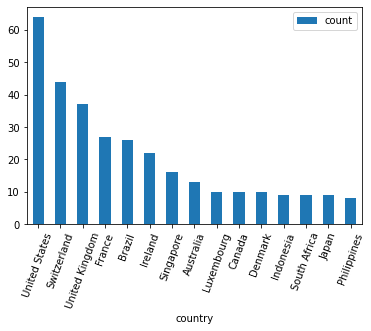

In [17]:
country_df.sort_values('count', ascending=False).head(15).plot.bar(x='country', rot=70)

## Machine learning approach

While the list approach quickly produced results it is rather simplistic. Imagine we wanted to identify locations or areas such as New York, South-East Asia or The European Union. With just a list of possible locations that would be very difficult.

Instead we break down and analyse the text and using Natural Language Processing (NLP). 

The process of is rather complex as seen in the chart below. Fortunately a lot of the heavy lifting is handled by the `nltk` library and for this usecase we can omit some of the steps.
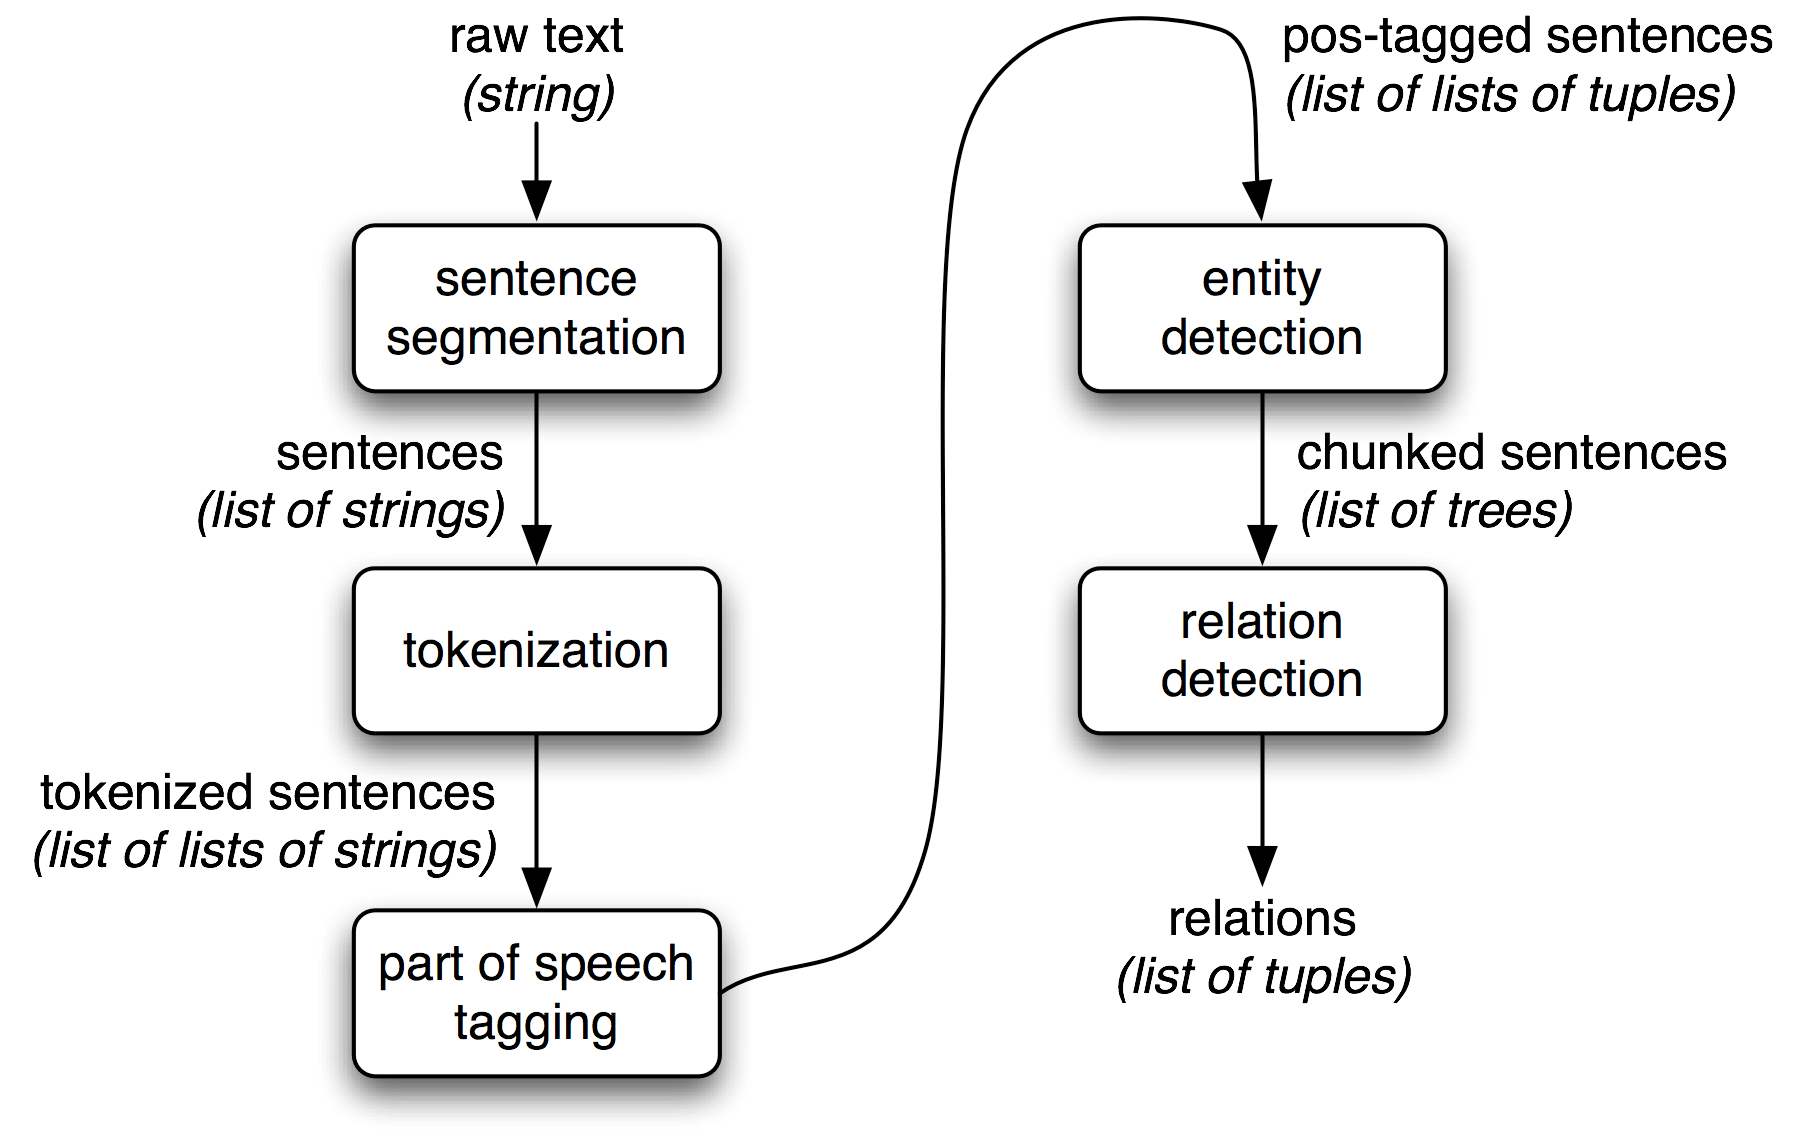
*[Information extraction architecture](https://www.nltk.org/book/ch07.html#fig-ie-architecture)*

First, we need to break our `text` into *tokens* using a tokenizer. In this step we convert the single, large string of text into a list of individual words and punctuation.

In [18]:
tokens = nltk.word_tokenize(text)

Next, we will use a part of speech (POS) tagger to classify each token with a linguistic label.

In [19]:
pos = nltk.pos_tag(tokens)

We will then feed the output into a chunker which will assign a label for each noun phrase. This is the process of named entity recognition (NER).

In [20]:
chunks = nltk.ne_chunk(pos)

The text is now converted into a tree-like structure and in order to extract information about specific labels we will need to iterate through the tree with a `for` loop.

In this case we are interested in *geo-political entities* (`GPE`).

In [21]:
locations = []
for tree in chunks:
    if isinstance(tree, nltk.Tree) and tree.label() == "GPE":
        location  = " ".join([word for word, pos in tree])
        locations.append(location)

We now have a list of locations found by the chunker. As before we can count the occurences and add them to a dictionary.

In [22]:
location_dict = dict()

for i in locations:
    if i in location_dict.keys():
        location_dict[i] += 1
    else:
        location_dict[i] = 1

Similarly, we can convert the data to a DataFrame for easier processing.

In [23]:
location_df = pd.DataFrame({'location': location_dict.keys(), 'count': location_dict.values()})

If we inspect the most frequent values, we can see that we get more than just countries, such as California, New York and EU. However, we also get company names and some terms that seem entirely unrelated to location.

In [26]:
location_df.sort_values('count', ascending=False).head(15)

,location,count
67,Service,119
6,California,113
9,Services,68
17,United States,61
28,EU,55
96,Us,48
77,New York,43
51,Google,41
7,Switzerland,40
2,English,38


There are different ways to tweak the methods to better suit our task, which you are encouraged to explore.

This notebook has illustrated two different ways to approach the same problem; each with their own strengths and limitations.